# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [41]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKmodel import HANKModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [63]:
model = HANKModelClass(name='baseline')

# Step 1: Steady state

In [64]:
model.find_ss(do_print=True)

steady state found in 7.8 secs
 beta   =   0.9874
 varphi =   0.8726

Discrepancy in B =  -0.00000000
Discrepancy in C =   0.00000000
Discrepancy in N =  -0.00000000


In [65]:
path = model.path
sim = model.sim
par = model.par
ss = model.ss


## Policy functions

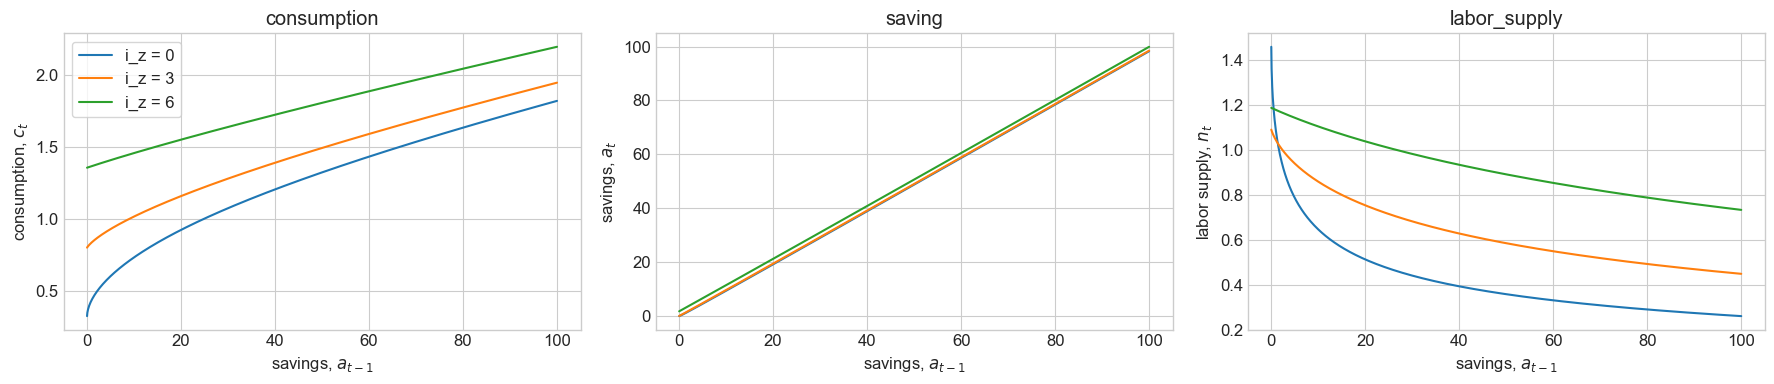

In [66]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

In [67]:
print("Steady state wage = ", ss.w)
print("Steady state B, G, A, A_HH, tau = ", ss.B, ss.G, ss.A, ss.A_hh, ss.tau)
print("Steady state interest rate", ss.r)
print("steady state consumption", ss.C, ss.C_hh)
print("steady state effective labor supply", ss.N, ss.N_hh)
print("Steady state laborsupply ell ", ss.ell)
print("varphi= ", par.varphi, "beta = ", par.beta)

Steady state wage =  0.749854141167587
Steady state B, G, A, A_HH, tau =  5.6 0.0 5.6 5.600000000004459 0.0
Steady state interest rate 0.0
Steady state marginal costs nan
steady state consumption 0.9041166009455166 0.9041166003402945
steady state effective labor supply 1.0 1.0000000000000195
Steady state laborsupply ell  [[[1.45829317 1.45106184 1.4437822  ... 0.26279857 0.26124219 0.25969093]
  [1.30751253 1.302738   1.29792489 ... 0.31620682 0.31440211 0.31260214]
  [1.17143562 1.16828651 1.16510869 ... 0.37915995 0.37708915 0.37502219]
  ...
  [1.089676   1.08959898 1.08952102 ... 0.53719576 0.53458712 0.53197828]
  [1.12774705 1.12770411 1.12766065 ... 0.6328573  0.63001654 0.62717225]
  [1.1865474  1.18651857 1.18648939 ... 0.73854824 0.73553566 0.73251545]]]
varphi=  0.8726341020857852 beta =  0.9873581600108791


## Simulation

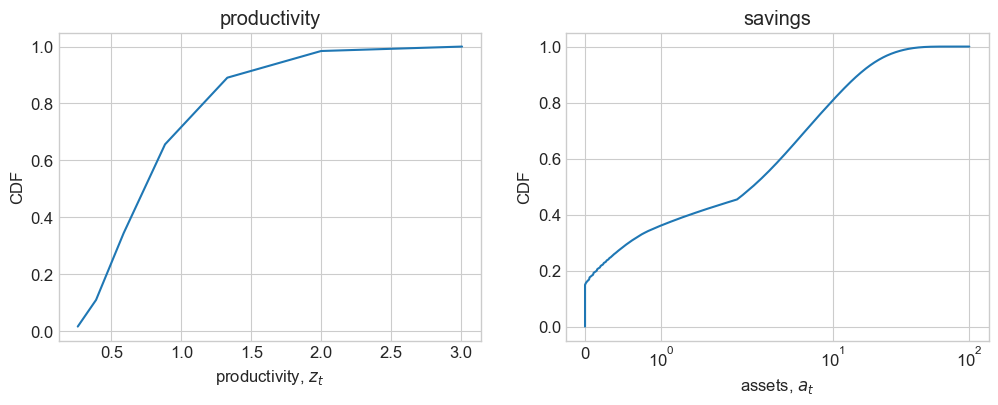

In [68]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

In [ ]:
model.test_hh_path()

**Full transition path:**

In [ ]:
model.test_path()

In [ ]:
model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [ ]:
par.jump_istar = -0.10/4
model.find_transition_path(do_print=True)

## Plot transitions

In [ ]:
paths = ['i','pi','r','C']
lvl_value = ['i','pi','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [ ]:
model.find_IRFs(do_print=True)

In [ ]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()